In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import itertools

In [ ]:
with open("portfolio-graph.pkl", "rb") as f:
  wow_graph = pickle.load(f)

In [ ]:
def get_bbl_subgraph(g, bbl):
    for c in nx.connected_components(g):
        induced_subgraph = g.subgraph(c)
        for node in induced_subgraph.nodes(data=True):
            if bbl in node[1]["bbls"]:
                return induced_subgraph
            
def get_edge_colors(graph, highlight_edges=False):
  edges = nx.get_edge_attributes(graph, "type").items()
  mapping = {'bizaddr': 'blue', 'name': 'red'}
  def get_edge_color(edge):
    if highlight_edges:
      # order of nodes in edge tuple can differ
      highlight_edges_sets = [set(x) for x in highlight_edges]
      if set(edge[0]) in highlight_edges_sets:
        return 'black'
    return mapping[edge[1]]
  return [get_edge_color(edge) for edge in edges]
    
def draw_graph(g, bbl=False, highlight_edges=False, with_labels=False):
  min_size = 10
  if bbl:
    node_sizes = [len(n[1]['bbls']) + min_size for n in g.nodes(data=True)]
  else:
    node_sizes = min_size
  kwargs = {
      'node_size':  node_sizes,
      'edge_color': get_edge_colors(g, highlight_edges),
      'alpha': 0.6,
      'node_color': ['gold' if bbl in n[1]['bbls'] else 'black' for n in g.nodes(data=True)],
      # 'cmap': plt.cm.winter_r
    }
  nx.draw_networkx(g, with_labels=with_labels, **kwargs)
  plt.axis("off")
  plt.show()

def draw_wow_graph_for_bbl(wow_graph, bbl, with_labels=False):
  print(f"BBL: {bbl}")
  g = get_bbl_subgraph(wow_graph, bbl)
  nested_bbls = [n[1]["bbls"] for n in g.nodes(data=True)]
  bbls = list(itertools.chain.from_iterable(nested_bbls))
  print("bbls: ", len(set(bbls)))
  print("dup bbls: ", len(bbls) - len(set(bbls)))
  draw_graph(g, bbl, with_labels)

In [ ]:
# g = get_bbl_subgraph(wow_graph_old, '2042900008')
# nested_bbls = [n[1]["bbls"] for n in g.nodes(data=True)]
# bbls_old = list(itertools.chain.from_iterable(nested_bbls))

# g = get_bbl_subgraph(wow_graph_new, '2042900008')
# nested_bbls = [n[1]["bbls"] for n in g.nodes(data=True)]
# bbls_new = list(itertools.chain.from_iterable(nested_bbls))

# print("new not in old")
# print([x for x in set(bbls_new) if x not in set(bbls_old)])
# print("old not in new")
# print([x for x in set(bbls_old) if x not in set(bbls_new)])

BBL: 1001420025
bbls:  172
dup bbls:  0


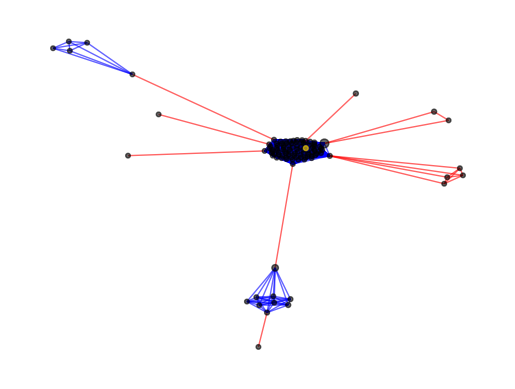

BBL: 2042900008
bbls:  76
dup bbls:  0


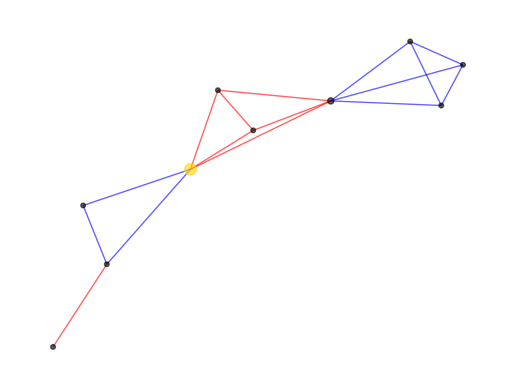

BBL: 3019250007
bbls:  151
dup bbls:  0


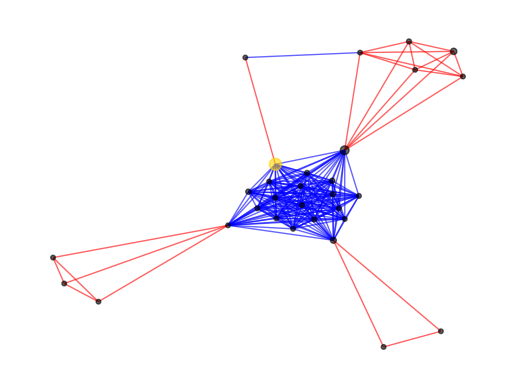

BBL: 4015640058
bbls:  174
dup bbls:  0


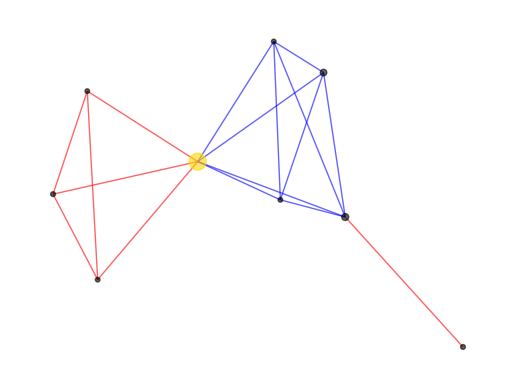

BBL: 1004120042
bbls:  235
dup bbls:  0


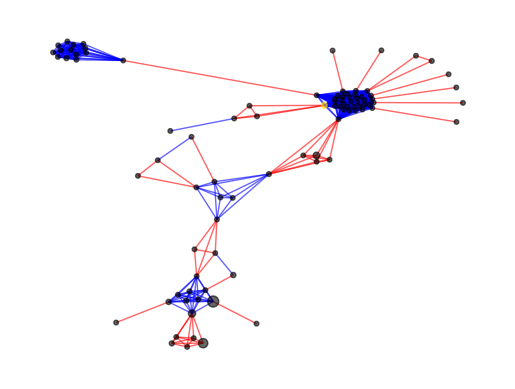

BBL: 4015640058
bbls:  174
dup bbls:  0


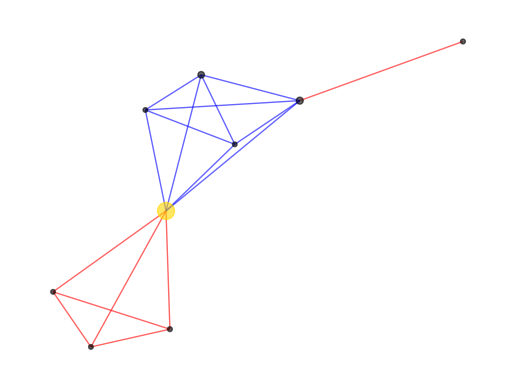

In [42]:
draw_wow_graph_for_bbl(wow_graph, '1001420025')
draw_wow_graph_for_bbl(wow_graph, '3019250007')
draw_wow_graph_for_bbl(wow_graph, '1004120042')
draw_wow_graph_for_bbl(wow_graph, '2042900008') # Steller
draw_wow_graph_for_bbl(wow_graph, '4015640058') # A&E
# draw_wow_graph_for_bbl(wow_graph, '3013420039') # The big one!

In [ ]:
subgraph = get_bbl_subgraph(wow_graph, "1004120042")
cutedges = list(nx.minimum_edge_cut(subgraph))
print(f"Need to cut the these {len(cutedges)} edges to split the porfolio.\n{cutedges}")
draw_graph(subgraph, "1001420025", highlight_edges=cutedges)

In [ ]:
subgraph = get_bbl_subgraph(wow_graph, "1004120042")

edges_bc = nx.edge_betweenness_centrality(subgraph)
max_edges = [x[0] for x in edges_bc.items() if x[1] == max(edges_bc.values())]
draw_graph(subgraph, highlight_edges=max_edges)

We need to decide when to attempt splitting a portfolio (including recusive). The first criteria should probably just be the size by number of properties, since that's very quick to calculate and we can have a pretty good idea of what the upper bound of reasonable size is via research. However, below that threshold we need another method to know if we suspect a grouping to be one larger portfolio or multiple smaller ones. 

There are various algorithms to calculate different statistics that may be useful here - like connectivity, clustering, etc. These seem to take a long time to run, which to some extent may be ok since we only have to recreate the portfolios once a month. However, there are also a set of [approximations](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.connectivity.node_connectivity.html) that are way faster and might work well enough for this our purpose.

One that seems promising is [`average_clustering`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.clustering_coefficient.average_clustering.html), which estimates an approximated average clustering coefficient for a graph. 

Clustering algorithms to identify communities.
https://memgraph.com/blog/graph-clustering-algorithms-usage-comparison

[`louvain_communities`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html) and [`greedy_modularity_communities`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html)

These both optiize for "modularity", using different approaches. Modularity of a network partition is high when there are dense connections between the nodes within communities but sparse connections between nodes in different communities. You can also adjust the `resolution` parameter to favor larger or smaller communities.

`greedy_modularity_communities` finds communities of nodes by starting with each node as its own community then joining communities if doing so increases the modularity of the network. 

`louvain_communities` ...


Examples:

`2042900008` - Settler Management (bbls=77) (one of our WOW example portfolios). Both algorithms (`greedy_modularity_communities (resolution=0.9)`, and `louvain_communities (resolution=1)`) don't split this any further.

`4015640058` - A&E Real Estate (bbls=173) (our other example portfolio). 



BBL: 1004120042
Original Portfolio


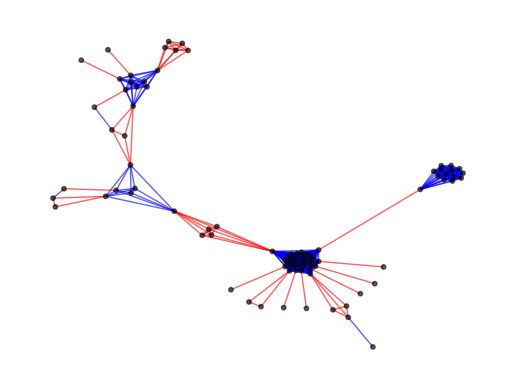

Communities (4) (resolution=0.9)
approximation.average_clustering: 0.829


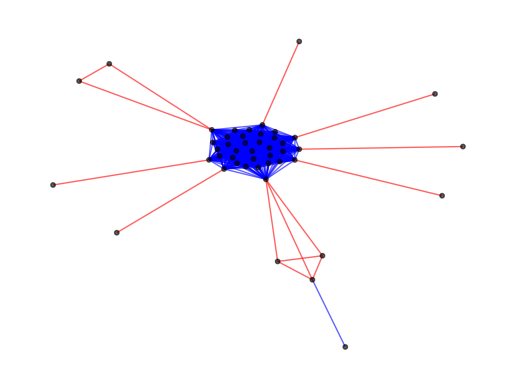

approximation.average_clustering: 0.705


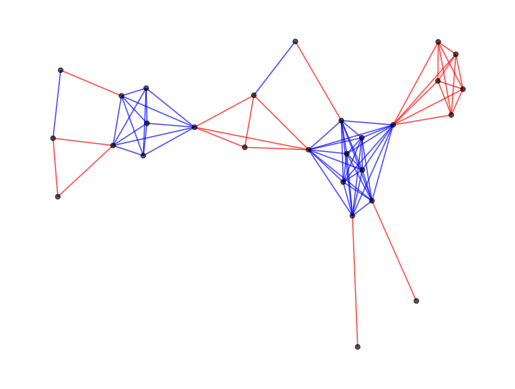

approximation.average_clustering: 1.0


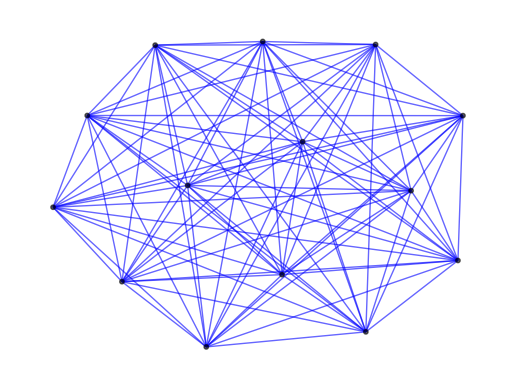

approximation.average_clustering: 1.0


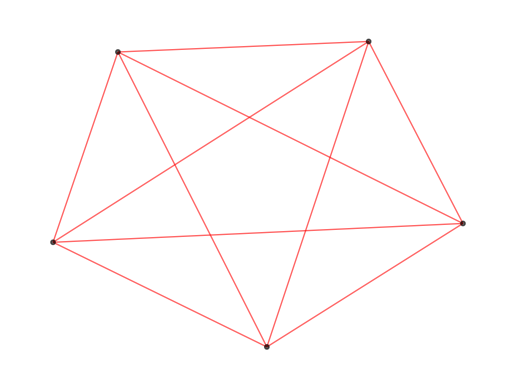

In [45]:
from networkx.algorithms import community
from networkx.algorithms import approximation

bbl = "1004120042"

subgraph = get_bbl_subgraph(wow_graph, bbl)

print(f"BBL: {bbl}")
print("Original Portfolio")
draw_graph(subgraph)

res = 0.9
communities = community.greedy_modularity_communities(subgraph, resolution=res)
print(f"Communities ({len(communities)}) (resolution={res})")
for comm in communities:
    comm_graph = nx.subgraph(subgraph, comm)
    score = approximation.average_clustering(comm_graph)
    print(f"approximation.average_clustering: {score}")
    draw_graph(comm_graph)

BBL: 4015640058
Original Portfolio


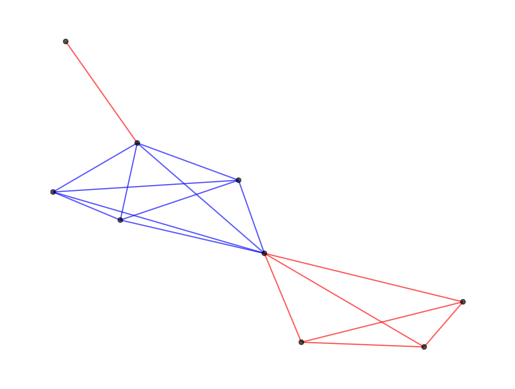

Communities (1) (resolution=0.1)
approximation.average_clustering: 0.761


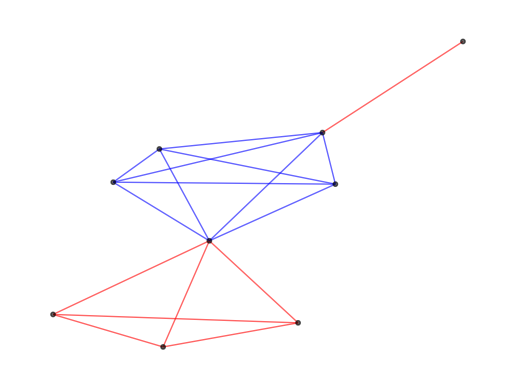

In [43]:
from networkx.algorithms import community
from networkx.algorithms import approximation

bbl = "4015640058"

subgraph = get_bbl_subgraph(wow_graph, bbl)

print(f"BBL: {bbl}")
print("Original Portfolio")
draw_graph(subgraph)

res = 0.1
communities = community.louvain_communities(subgraph, resolution=res)
print(f"Communities ({len(communities)}) (resolution={res})")
for comm in communities:    
    comm_graph = nx.subgraph(subgraph, comm)
    score = approximation.average_clustering(comm_graph)
    print(f"approximation.average_clustering: {score}")
    draw_graph(comm_graph)

This method uses [`kernighan_lin_bisection`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.kernighan_lin.kernighan_lin_bisection.html) to split a portfolio. At first on some examples this seems to do a nice job finding natural groupings, however it tries to split the graph into two sets of nodes with roughly the same number, so this won't work. You can see in the example below that there is a huge highly connected concentration, but it can't put those all in one partition and keep that size balance, so it just takes a subset from that cluster, actually breaking up what we might want to be extracting. 

In [ ]:
from networkx.algorithms import community

bbl = "1001420025"

subgraph = get_bbl_subgraph(wow_graph, bbl)

print(f"BBL: {bbl}")
print("Original Portfolio")
draw_graph(subgraph)

print("community.kernighan_lin_bisection")
splitgraph = community.kernighan_lin_bisection(subgraph, max_iter=1000)

draw_graph(nx.subgraph(subgraph, splitgraph[0]))
draw_graph(nx.subgraph(subgraph, splitgraph[1]))